# STAGE 3: SHAP Explainability for Random Forest (Optimised)

This notebook loads the **depth-optimised** Random Forest model (`rf_anomaly_classifier_optimised.pkl`) from `./artifacts/` and uses **SHAP TreeExplainer** to generate:
1. Global feature importance (bar + beeswarm plots)
2. Local waterfall explanation for individual anomalies
3. Dependence plots for top features

> **Prerequisites:** Run `02_random_forest.ipynb` first — specifically the depth-sweep and retrain cells — so that `rf_anomaly_classifier_optimised.pkl` exists.

In [1]:
import joblib
import shap
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os

# ── Setup ────────────────────────────────────────────────────────────────────
ART_DIR = "./artifacts"

# Load the OPTIMISED model (depth-tuned in notebook 02)
MODEL_PATH = os.path.join(ART_DIR, "rf_anomaly_classifier_optimised.pkl")
if not os.path.exists(MODEL_PATH):
    # Fallback to the original model if optimised doesn't exist yet
    MODEL_PATH = os.path.join(ART_DIR, "rf_anomaly_classifier.pkl")
    print(f"⚠ Optimised model not found — falling back to: {MODEL_PATH}")

rf = joblib.load(MODEL_PATH)

# Print model info so we know exactly what we're explaining
print(f"✓ Loaded model: {MODEL_PATH}")
print(f"  max_depth   = {rf.max_depth}")
print(f"  n_estimators = {rf.n_estimators}")
print(f"  min_samples_split = {rf.min_samples_split}")
print(f"  min_samples_leaf  = {rf.min_samples_leaf}")

# ── Rebuild the exact same train/test split ──────────────────────────────────
df_labeled = pd.read_csv(f"{ART_DIR}/bccc_labeled_high_confidence.csv")
y = df_labeled["pseudo_label"]
X = df_labeled.drop(columns=["pseudo_label", "confidence_score", "if_anomaly", "ae_anomaly"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n✓ X_test shape: {X_test.shape}")
print(f"  Test anomalies: {int(y_test.sum())}")

# ── SHAP TreeExplainer ───────────────────────────────────────────────────────
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

print(f"\n=== SHAP OUTPUT ===")
print(f"Raw shap_values shape: {shap_values.shape}")

# Extract anomaly class (class 1)
shap_values_anomaly = shap_values[:, :, 1]

print(f"\n✓ Extracted anomaly class SHAP values")
print(f"  shap_values_anomaly shape: {shap_values_anomaly.shape}")

assert shap_values_anomaly.shape == X_test.shape, \
    f"Shape mismatch! SHAP: {shap_values_anomaly.shape} vs X_test: {X_test.shape}"
print("✓✓ SHAPES MATCH!")

# Save
np.save(f"{ART_DIR}/shap_values_anomaly.npy", shap_values_anomaly)
joblib.dump(explainer, f"{ART_DIR}/shap_explainer.pkl")
print("✓ Saved shap_values_anomaly.npy and shap_explainer.pkl")

✓ Loaded model: ./artifacts/rf_anomaly_classifier_optimised.pkl
  max_depth   = 11
  n_estimators = 300
  min_samples_split = 20
  min_samples_leaf  = 10

✓ X_test shape: (5108, 50)
  Test anomalies: 74

=== SHAP OUTPUT ===
Raw shap_values shape: (5108, 50, 2)

✓ Extracted anomaly class SHAP values
  shap_values_anomaly shape: (5108, 50)
✓✓ SHAPES MATCH!
✓ Saved shap_values_anomaly.npy and shap_explainer.pkl


## Global Explanation (Bar + Beeswarm)
These show which features matter most across all test samples.

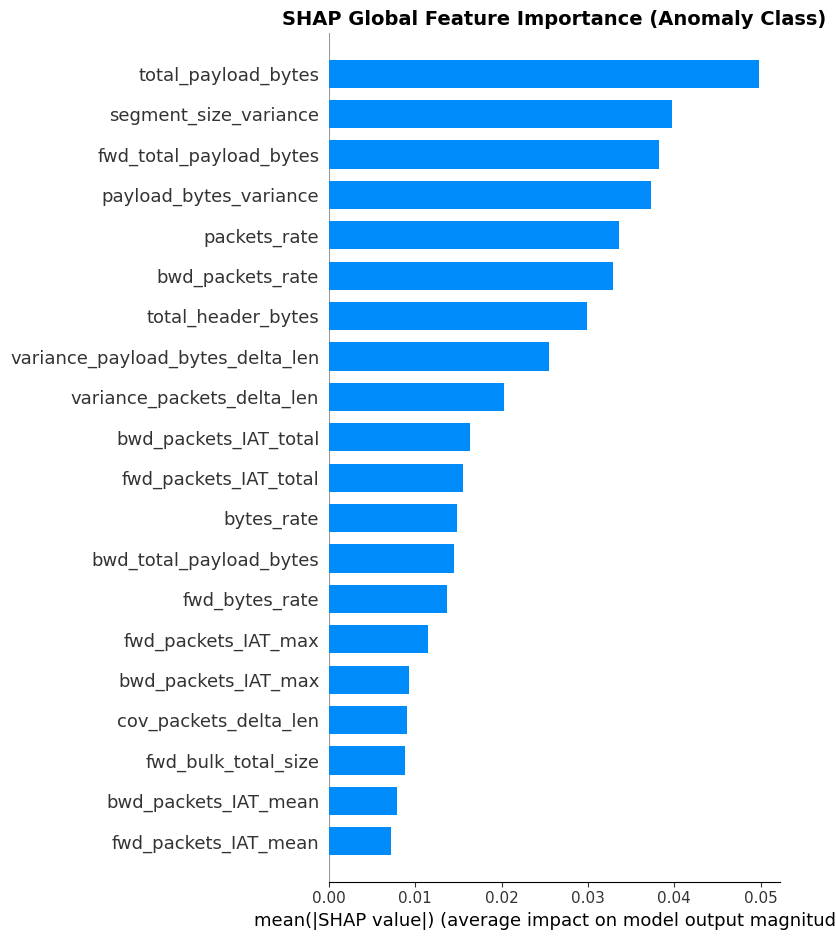

✓ Saved shap_summary_bar.png


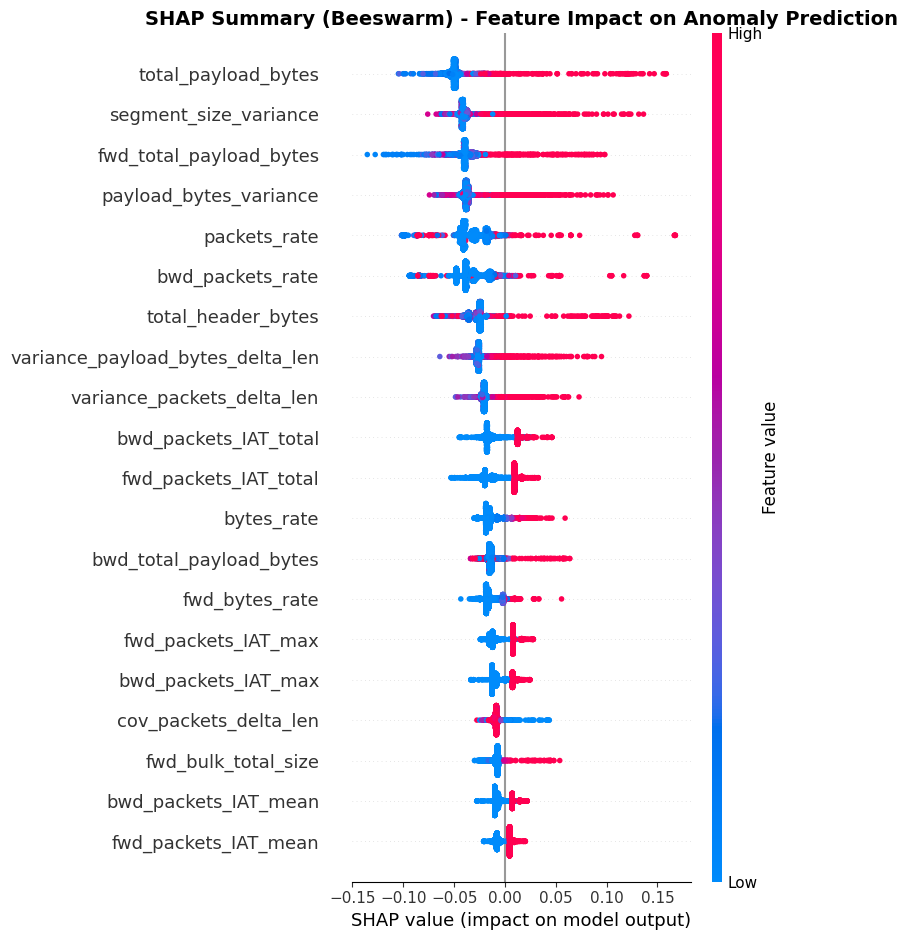

✓ Saved shap_summary_beeswarm.png


In [2]:
import matplotlib.pyplot as plt
import shap

# 1) Bar plot - global feature importance
plt.figure(figsize=(12, 7))
shap.summary_plot(shap_values_anomaly, X_test, plot_type="bar", max_display=20, show=False)
plt.title("SHAP Global Feature Importance (Anomaly Class)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{ART_DIR}/shap_summary_bar.png", dpi=300, bbox_inches="tight")
plt.show()

print("✓ Saved shap_summary_bar.png")

# 2) Beeswarm plot - feature impact distribution
plt.figure(figsize=(12, 9))
shap.summary_plot(shap_values_anomaly, X_test, max_display=20, show=False)
plt.title("SHAP Summary (Beeswarm) - Feature Impact on Anomaly Prediction", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{ART_DIR}/shap_summary_beeswarm.png", dpi=300, bbox_inches="tight")
plt.show()

print("✓ Saved shap_summary_beeswarm.png")


## Local Explanation (Waterfall)
Explains a single anomalous sample — useful for thesis/report screenshots.

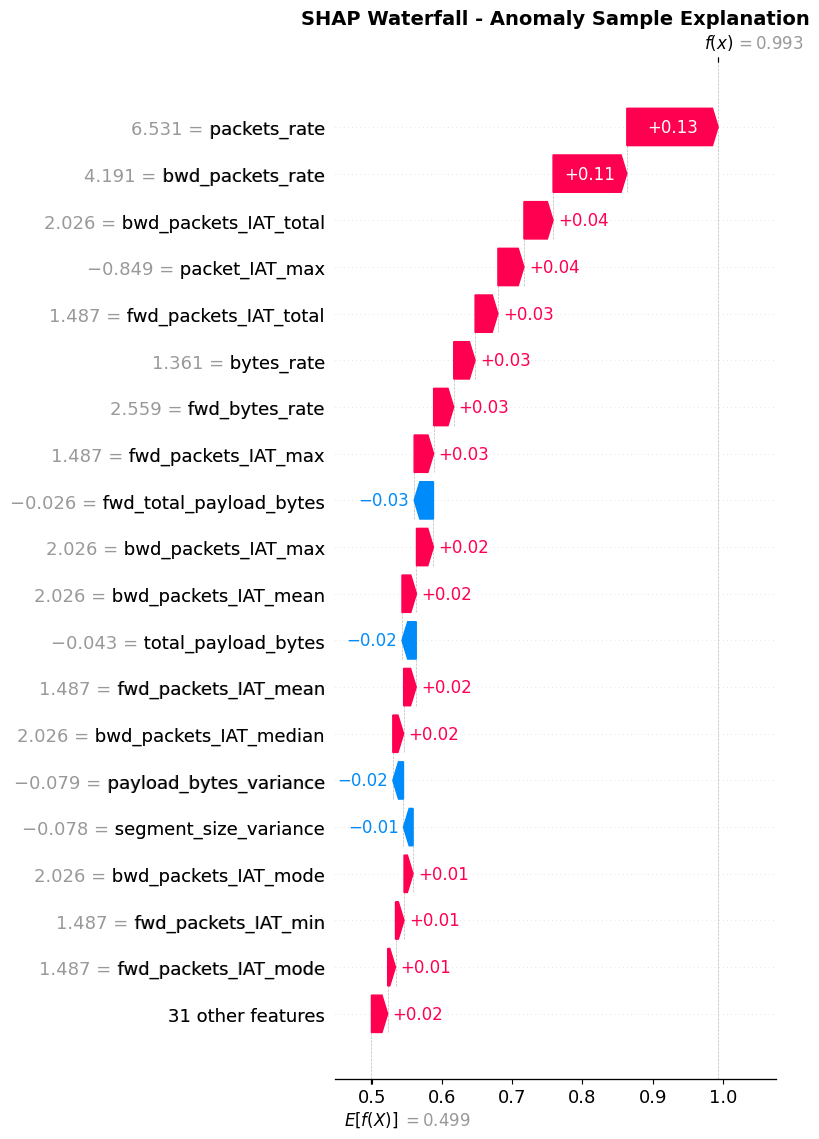

✓ Saved shap_waterfall_anomaly.png


In [3]:
# Find one true anomaly from test set
anomaly_indices = np.where(y_test.values == 1)[0]

if len(anomaly_indices) > 0:
    idx = anomaly_indices[0]  # Pick first anomaly
    x_row = X_test.iloc[idx]
    
    # Create SHAP Explanation object
    exp = shap.Explanation(
        values=shap_values_anomaly[idx],
        base_values=explainer.expected_value[1],  # Base value for class 1
        data=x_row.values,
        feature_names=X_test.columns.tolist()
    )
    
    plt.figure(figsize=(12, 6))
    shap.plots.waterfall(exp, max_display=20, show=False)
    plt.title("SHAP Waterfall - Anomaly Sample Explanation", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f"{ART_DIR}/shap_waterfall_anomaly.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    print("✓ Saved shap_waterfall_anomaly.png")
else:
    print("No anomalies found in test set")


## Dependence Plot (Top Feature)
Shows how the top feature's value drives the anomaly prediction.

Top SHAP feature: total_payload_bytes


<Figure size 1000x600 with 0 Axes>

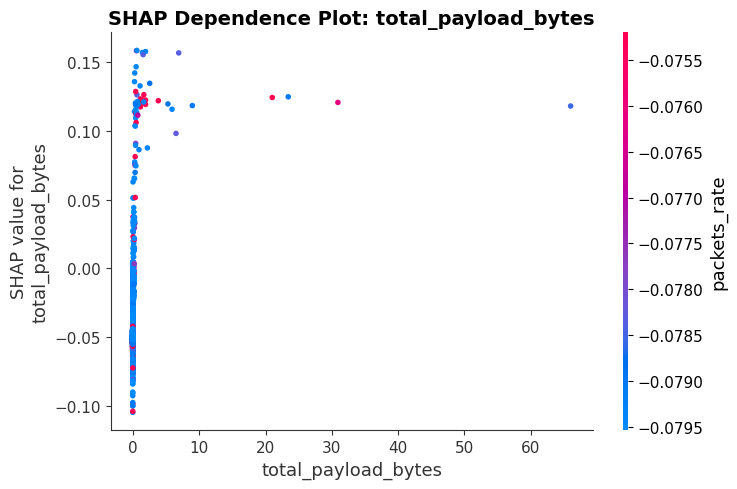

✓ Saved shap_dependence_top_feature.png


In [4]:
# Find top feature by mean |SHAP|
mean_abs_shap = np.abs(shap_values_anomaly).mean(axis=0)
top_feature_idx = np.argmax(mean_abs_shap)
top_feature = X_test.columns[top_feature_idx]

print(f"Top SHAP feature: {top_feature}")

plt.figure(figsize=(10, 6))
shap.dependence_plot(top_feature, shap_values_anomaly, X_test, show=False)
plt.title(f"SHAP Dependence Plot: {top_feature}", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{ART_DIR}/shap_dependence_top_feature.png", dpi=300, bbox_inches="tight")
plt.show()

print("✓ Saved shap_dependence_top_feature.png")
